## Séparation de jeux d'échantillons de référence en jeux d'entrainement et de validation

Dans le précédent TD nous avons vu un chaine de traitements simplifiée dans laquelle la validation du modèle se faisait sur le même jeux de données que celui qui avait servi à faire la validation ce qui est une mauvaise chose car nous n'avons aucune idée de la qualité de notre de classification sur des pixels inconnus. 

### Cas où on a beaucoup d'échantillons

Il faut en réalité toujours séparer son jeux d'échantillons entre un jeu d'apprentissage (ou "train") et un jeu de validation (ou "test"). Vous pouvez voir ci-dessous la chaine de traitements mis à jour : 

![](../../img/td_classification_part2/classification_process_v2.png)

Dans le cas où vous disposez de nombreux échantillons, comme pour ceux du jeux de données issu de `sample_strata.shp`(plus de 25 000 pixels), vous pouvez conserver une majorité des échantillons pour avoir une validation plus robuste. Nous garderons dans cette partie 70% des pixels pour la validation.

Cette opération peut se faire avec la fonction `train_test_split` du module `model_selection` de ==Scikit-Learn== :

In [85]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')
import os
from sklearn.model_selection import train_test_split

# personal librairies
import classification as cla


# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# 2 --- extract samples 
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)

# split samples
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7)

Cette fonction permet de séparer de manière aléatoire vos matrices de variable (`X`) et de labels (`Y`) en deux jeux différents.

Remarque : vous pouvez au besoin renseigner l'argument `random_state` pour pouvoir appliquer la même séparation "aléatoire" sur plusieurs jeux de données différents (voir détails sur la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) de la fonction). 

Exercice

1. Testez plusieurs fois la fonction `train_test_split` et vérifiez que la séparation est bien aléatoire ;
2. Rajoutez l'étape de séparation des échantillons dans le script de classification complet que vous avez produit lors de la dernière séance et corrigez le en conséquence ;
3. Lancez la classification  :

    3.1. Commentez les résulats : sont-ils similaires à ce que vous avez trouvé dans le précédent TD ?
    3.2. Re-lancez plusieurs fois la classification pour voir si vous obtenez des résulats différents ? 
    3.3. Changez la proportion d'échantillons utilisée pour l'entrainement pour voir si cela influence les résultats.

Solution

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


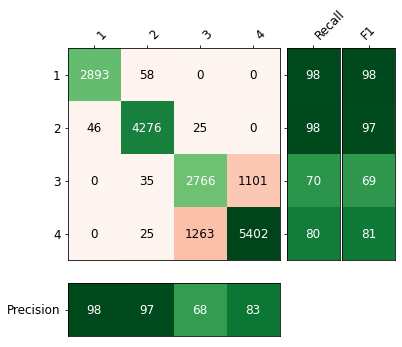

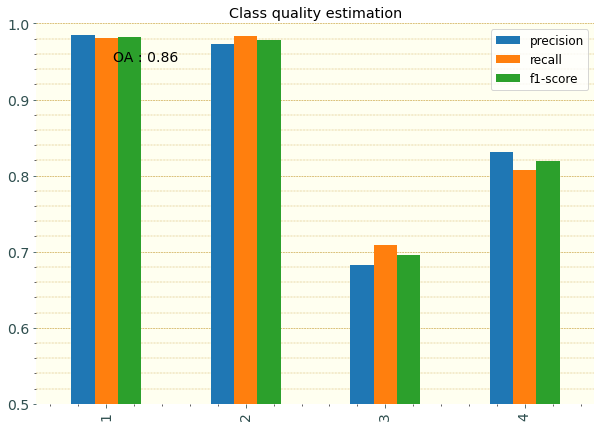

In [90]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.7

# outputs
suffix = '_v2'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))

# 2 --- extract samples 
X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


# 3 --- Train
#clf = SVC(cache_size=6000)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X_train, Y_train)

# 4 --- Test
Y_predict = clf.predict(X_test)

# compute quality
cm = confusion_matrix(Y_test, Y_predict)
report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)
accuracy = accuracy_score(Y_test, Y_predict)

# display and save quality
plots.plot_cm(cm, np.unique(Y_predict), out_filename=out_matrix)
plots.plot_class_quality(report, accuracy, out_filename=out_qualite)

# 5 --- apply on the whole image

# load image
X_img, _, t_img = cla.get_samples_from_roi(image_filename, image_filename)

# predict image 
Y_img_predict = clf.predict(X_img)

# reshape 
ds = rw.open_image(image_filename)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

#initialization of the array
img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
img[t_img, t_img, 0] = Y_img_predict

# write image
ds = rw.open_image(image_filename)
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=None,
            transform=None, projection=None, driver_name=None,
            nb_col=None, nb_ligne=None, nb_band=1)

Remarque : dans ce cas la classification n'est produite qu'à partir de 70% des échantillons originaux. 

### Problème : les jeux d'entrainement et de validation sont-ils vraiment indépendants ? 

Nous avons certes séparé de manière aléatoire nos pixels échantillons en un jeu de validation et d'entrainement mais ... sans tenir compte de leur appartenance à un même polygone ! Or, deux pixels appartenant au même polygone sont probablement très similaires : s'entraîner sur l'un et tester sur l'autre peut entraîner un biais dans l'estimation de la qualité du modèle. 

Une solution à ce problème est de ne sélectionner qu'un pixel de chaque polygone. Vous avez à votre disposition un fichier `sample_strata_centroides.shp` qui correspond à un fichier de points ou chaque point est le centroïde d'un polygone du fichier `sample_strata.shp`.

Cela implique par contre d'extraire les valeurs spectrales à partir d'un fichier de points et non plus de polygone. Je vous propose ainsi une autre méthode que celle vue précédemment pour réaliser l'extraction.

INSERTION PARTIE EXTRACTION

Vous savez maintenant extraire les valeurs spectrales d'échantillons sous forme de points, et nous n'avons plus de problèmes liés à des pixels appartenant au même polygone.

Exercice

Écrivez une chaîne de traitement pour en entrainer et valider un modèle de classification avec :
- séparation des échantillons en deux jeux d'entrainement et de validation
- en utilsant le jeux d'échantillons `sample_strata_centroides.shp`

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


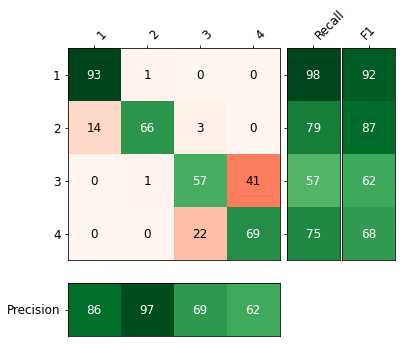

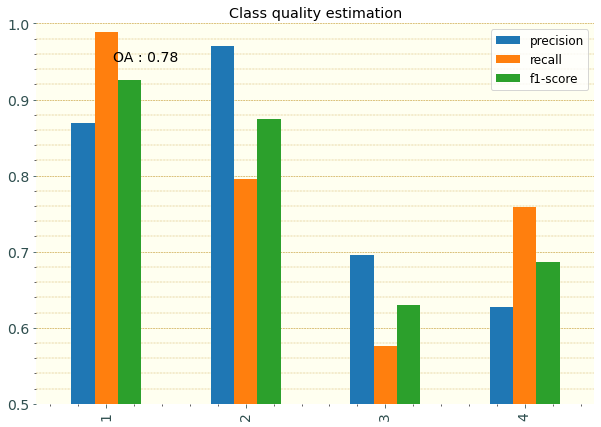

In [89]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.7
is_point = True
# if is_point is True
field_name = 'num' 

# outputs
suffix = '_v2bis'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples 
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)
else : 
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]
    
    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T
    
    # split sample
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


# 3 --- Train
#clf = SVC(cache_size=6000)
clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X_train, Y_train)

# 4 --- Test
Y_predict = clf.predict(X_test)

# compute quality
cm = confusion_matrix(Y_test, Y_predict)
report = classification_report(Y_test, Y_predict, labels=np.unique(Y_predict), output_dict=True)
accuracy = accuracy_score(Y_test, Y_predict)

# display and save quality
plots.plot_cm(cm, np.unique(Y_predict), out_filename=out_matrix)
plots.plot_class_quality(report, accuracy, out_filename=out_qualite)


### Cas où on a peu d'échantillons

Lorsque vous avez pallié au problème des échantillons appartenant au même polygone en utilisant le fichier `sample_strata_centroides.shp`, vous avez avez diminué de fait le nombre d'échantillons disponible pour l'entrainement et la validation. Il est alors légitime de se poser la question suivante : **les performances de mon modèle de classification sont-elles influencées par le résulat de la séparation de mon jeux de données en un jeu de validation et d'entrainement ?**

Pour répondre à cette question, je vous propose deux choix : 
- répéter plusieurs fois l'entrainement et la validation de votre modèle ;
- utiliser une validation croisée.

#### Répéter plusieurs fois la validation

Dans cette partie, je vous propose de répéter plusieurs fois l'entrainement et la validation de votre modèle avec des séparations de votre jeux d'échantillons différentes à chaque itération (voir figure ci-dessous) :

![](../../img/td_classification_part2/classification_process_v3.png)

Les indices de qualité sont produits plusieurs fois, vous devrez les moyenner à la fin pour obtenir une estimation moyenne de la qualité de votre modèle de classification.

Exercice

Vous disposez d'une fonction `report_from_dict_to_df` qui permet de convertir en `DataFrame` un dictionnaire retourné par la fonction `classification_report` : 

In [1]:
def report_from_dict_to_df(dict_report):
    
    # convert report into dataframe
    report_df = pd.DataFrame.from_dict(dict_report)
    
    # drop unnecessary rows and columns 
    report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    report_df = report_df.drop(['support'], axis=0)
    
    return report_df

1. Écrivez une série d'instructions pour répéter `nb_iter = 30` l'entrainement et la validation d'un modèle de classification.
2. Stocker :
    - les matrices de confusion dans une liste `list_cm`,
    - les accords globaux dans une liste `list_accuracy`.
    - les rapport de classification sous forme de **`DataFrame`** dans une liste `list_report` .

In [37]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.5
is_point = True
# if is_point is True
field_name = 'num' 

# outputs
suffix = '_v2'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))

# 2 --- extract samples 
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else : 
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

for i in range(30):  
    # Split sample 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, 
    
                                   labels=np.unique(Y_predict), output_dict=True)
    # store them
    list_report.append(report_from_dict_to_df(report))

Il faut ensuite calculer la moyenne et éventuellement l'écart type des nos différentes itérations.

Matrice de confusion

Calcul

In [43]:
nb_iter = 30
# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)


Affichage

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


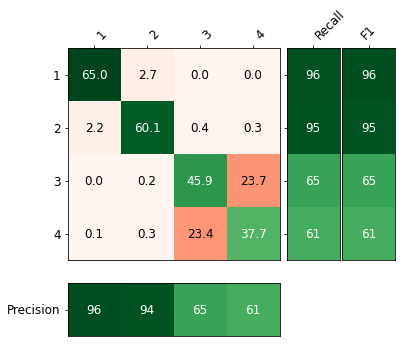

In [44]:
plots.plot_cm(mean_cm, np.unique(Y_predict))

Calcul de l'Accord global moyen

In [40]:
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

Moyenne des rapports de classification

In [42]:
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)

Affichage des qualités 

Nous reconvertir les tableaux ==Numpy== en `DataFrame` de ==Pandas== pour afficher simplement les résulats :

In [46]:
mean_df_report = pd.DataFrame(mean_report)
mean_df_report

0         1         2         3
0  0.967300  0.949742  0.661429  0.615652
1  0.960181  0.954622  0.658473  0.616680
2  0.963369  0.951792  0.656258  0.611690

Au passage vous avez vu comment créer un `DataFrame` à partir d'un tableau ==Numpy==. Rajoutons maintenant les index à partir des précédents `DataFrame`.

In [50]:
a_report = list_report[0]
an_index = a_report.index
print(an_index)
a_column_index = a_report.columns
print(a_column_index)
mean_df_report = pd.DataFrame(mean_report, index=an_index,
                              columns=a_column_index)
mean_df_report

Index(['precision', 'recall', 'f1-score'], dtype='object')
Index(['1', '2', '3', '4'], dtype='object')


1         2         3         4
precision  0.967300  0.949742  0.661429  0.615652
recall     0.960181  0.954622  0.658473  0.616680
f1-score   0.963369  0.951792  0.656258  0.611690

Faisons la même chose pour l'écart type :

In [51]:
a_report = list_report[0]
an_index = a_report.index
print(an_index)
a_column_index = a_report.columns
print(a_column_index)
std_df_report = pd.DataFrame(std_report, index=an_index,
                            columns=a_column_index)
std_df_report

Index(['precision', 'recall', 'f1-score'], dtype='object')
Index(['1', '2', '3', '4'], dtype='object')


1         2         3         4
precision  0.025745  0.022252  0.053467  0.065903
recall     0.021208  0.032486  0.080829  0.077525
f1-score   0.014853  0.020531  0.047793  0.049819

Enfin affichons les résulats : 

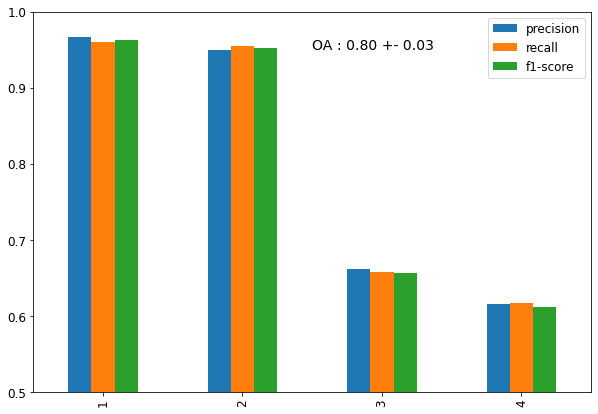

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)

En rajoutant des barres d'erreurs correspondant à l'écart type : 

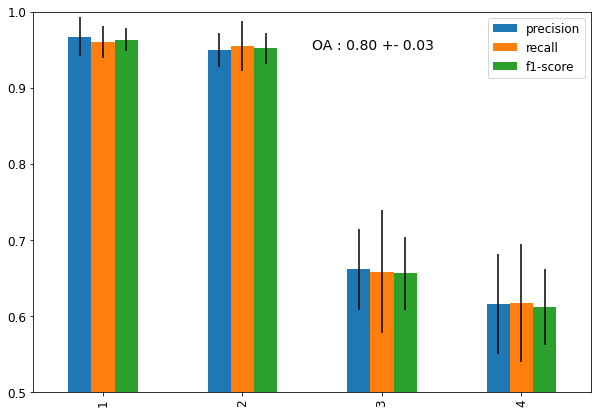

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)

En rajoutant quelques élements graphiques :

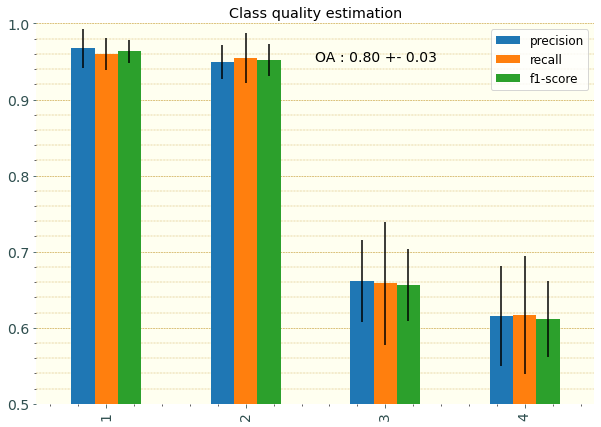

In [64]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)

Solution

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


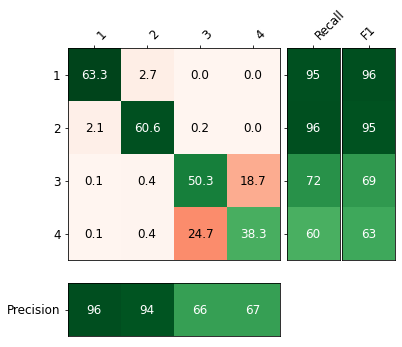

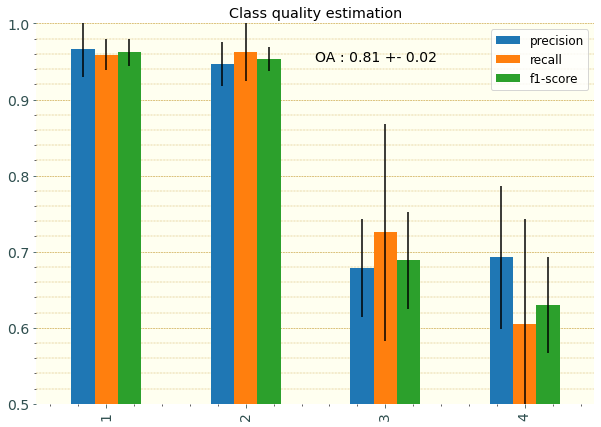

In [88]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
test_size = 0.5
is_point = True
# if is_point is True
field_name = 'num' 

# outputs
suffix = '_v3'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))

# 2 --- extract samples 
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else : 
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []

for i in range(30):  
    # Split sample 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)


    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=10)
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, 
    
                                   labels=np.unique(Y_predict), output_dict=True)
    # store them
    list_report.append(report_from_dict_to_df(report))


# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')


# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

#### Cross validation

Dans cette partie, je vous propose de répéter plusieurs fois l'entrainement et la validation de votre modèle avec des séparations de votre jeux d'échantillons différentes à chaque itération :

![](../../img/td_classification_part2/classification_process_v4.png)

Cette fois-ci non pas séparer les échantillons de manière tout à fait aléatoires. Nous allons créer $k$ paires de jeux de données complémentaires pour faire une validation croisée. 

Le principe est de diviser les échantillons en $k$ groupes (appelés *folds* en anglais) de taille égale. Le modèle est entrainé sur $k-1$ *folds* et le *fold* restant est utilisé pour la validation. Le processus est alors répété $k$ fois en utilisant un *fold* différent à chaque fois pour la validation. Vous pouvez voir ci-dessous un exemple issu de la documentation de ==Scikit-learn== où $k=4$ pour trois classes à classer.

![](../../img/td_classification_part2/k_fold.png)

On peut remarquer dans cet exemple que le label des classes n'est pas pris en compte lors de la création des $k$ *folds*. Il est alors possible de se retrouver avec de jeux de validation qui contiennent peu voire aucun échantillon d'une classe (surtout si une classe contient peu d'échantillons). Il est alors possible d'imposer que la proportion initiale de chaque classe soit conserver dans les folds. Vous pouvez voir ci-dessous un exemple issu de la documentation de ==Scikit-learn== où $k=4$ pour trois classes à classer. 

![](../../img/td_classification_part2/stratified_k_fold.png)

C'est cette dernière méthode que nous allons tester. Nous allons pour cela utiliser la classe `StratifiedKFold` du module `model_selection`. Elle s'utilise comme suit : 

In [78]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np


X, Y = np.ones((18, 1)), np.hstack(([0] * 12, [5] * 6))
print('X :', X.T)
print('Y :', Y)

# Intiatilise
skf = StratifiedKFold(n_splits=3)
# Iterations on skf
for index_train, index_test in skf.split(X, Y):
    print(index_test)
    X_train, X_test = X[index_train], X[index_test]
    Y_train, Y_test = Y[index_train], Y[index_test]
    
    # train
    # ....
    # test
    # ....
    # etc...

X : [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
Y : [0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5]
[ 0  1  2  3 12 13]
[ 4  5  6  7 14 15]
[ 8  9 10 11 16 17]


Exercice 

- Implémentez cette nouvelle stratégie de validation en stockant comme précédemment les indices de qualité au fur et à mesure qu'ils sont produits ;
- calculez ensuite la synthèse de ces indices et afficher les résulats sous forme de graphique ;
- commentez vos résulats.

Solution

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


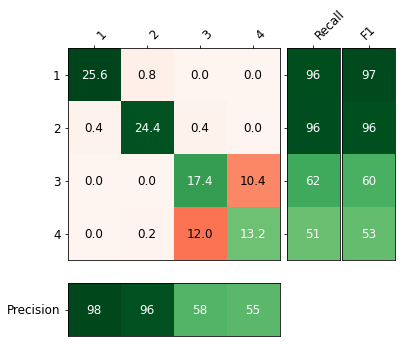

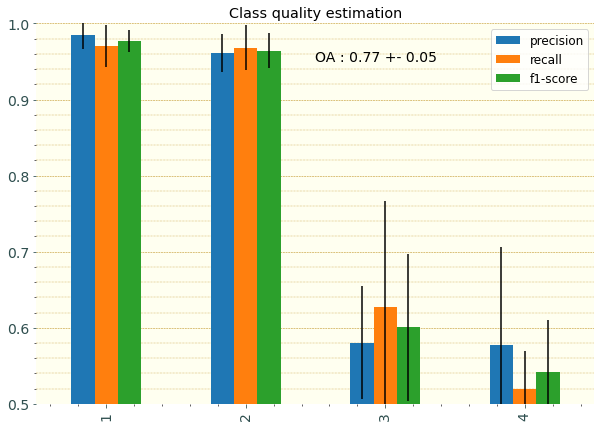

In [83]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
#test_size = 0.7
nb_iter =5
is_point = True
# if is_point is True
field_name = 'num' 

# outputs
suffix = '_v4'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples 
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else : 
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]
    
    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T
    
list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
kf = StratifiedKFold(n_splits=nb_iter)
for train, test in kf.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]
    
    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, 

                                   labels=np.unique(Y_predict), output_dict=True)
    
    # store them
    list_report.append(report_from_dict_to_df(report))



# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

#### Et la classification dans tous ça ? 

Vous avez vu dans la précédente partie deux manière d'estimer la qualité d'une classification lorsqu'on possède peu d'échantillons, mais ce genre de stratégie est tout à fait valable lorsque vous en possédez beaucoup. 

Dans tous les cas, vous pouvez produire une classification maintenant que vous avez estimé sa qualité, vous pouvez cette fois-ci utiliser tous les échantillons à votre disposition pour entrainer le model. Vous obtiendrez une carte très proche de celle produite dans le précédent TD. 

## Améliorer les résulats avec des traitements post-classification

### Filtre majoritaire pour supprimer l'effet poivre et sel

### Regroupement de classes (compromis entre précision thématique et statistique)

Une possibilité pour améliorer votre classification est de regrouper des classes qui ont beaucoup de confusion entre elles *a posteriori*. Dans notre cas, la classe "Ligneux bas" (classe 3) et "Ligneux hauts" ont beaucoup de confusion (classe 4).

#### Evaluation de la qualité 

Pour évaluer la qualité d'une classification vous comparez une matrice de référence `Y_test` avec une matrice `Y_predict` contenant les labels prédits par un modèle. Pour évaluer l'effet d'un regroupement de classe sur la qualité d'une classification il suffit de remplacer les valeurs de `Y_test` et `Y_predict` par celle souhaitée puis comparer les deux matrices. 

Exercice

Évaluez l'effet du regroupement de la classe 4 dans la classe 3 (il vous suffit de changer 3-4 lignes de codes dans votre script de classification de la partie précédente).

/home/terudel/Documents/code/MuseoToolBox/museotoolbox/charts/__init__.py:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(


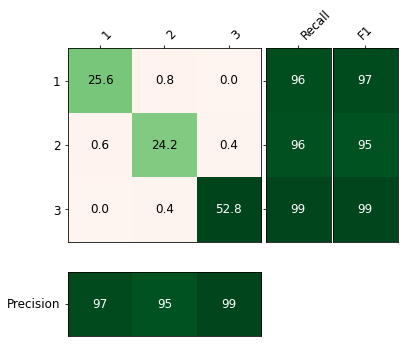

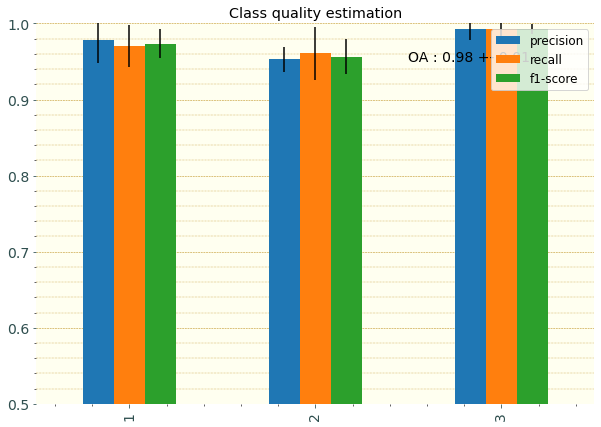

In [91]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
sample_filename = os.path.join(my_folder, 'sample_strata_centroides.shp')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')

# Sample parameters
#test_size = 0.7
nb_iter =5
is_point = True
# if is_point is True
field_name = 'num' 

# outputs
suffix = '_v4_regroup'
out_classif = os.path.join(my_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(my_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(my_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples 
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
else : 
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]
    
    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T
    
list_cm = []
list_accuracy = []
list_report = []

# Iter on stratified K fold
kf = StratifiedKFold(n_splits=nb_iter)
for train, test in kf.split(X, Y):
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]
    
    # 3 --- Train
    #clf = SVC(cache_size=6000)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, Y_train)

    # 4 --- Test
    Y_predict = clf.predict(X_test)

    Y_predict[Y_predict == 4] = 3
    Y_test[Y_test == 4] = 3
    # compute quality
    list_cm.append(confusion_matrix(Y_test, Y_predict))
    list_accuracy.append(accuracy_score(Y_test, Y_predict))
    report = classification_report(Y_test, Y_predict, 

                                   labels=np.unique(Y_predict), output_dict=True)
    
    # store them
    list_report.append(report_from_dict_to_df(report))
    


# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')

#### Regroupement de classe d'une classification 

Exercice

Maintenant que vous connaissez l'effet du regroupement sur la qualité de votre classification visualiser le résulat : 

1. Chargez l'image `ma_premiere_classif_scikit.tif` sous forme de tableau ;
2. Effectuez les changements grace à numpy ;
3. Écrivez le résulat dans une image `ma_premiere_classif_scikit_regroup.tif`

In [96]:
import sys
sys.path.append('/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/python_scripts')

import os
import numpy as np
# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters 
# inputs
my_folder = '/home/terudel/Documents/cours/2020-2021/SIGMA/teledec_avance/data/aumelas/'
classif_filename = os.path.join(my_folder, 'ma_premiere_classif_scikit.tif')
out_regoup_filename = os.path.join(my_folder, 'ma_premiere_classif_scikit_regroup.tif')

classif = rw.load_img_as_array(classif_filename)
classif[classif==4] = 3
ds = rw.open_image(classif_filename)
rw.write_image(out_regoup_filename, classif, data_set=ds)

## Cas d'application